In [12]:
import matplotlib.pyplot as plt
import cv2 
import numpy as np

In [14]:
image_size = 28 # width and length
no_of_different_labels = 10 #  i.e. 0, 1, 2, 3, ..., 9
image_pixels = image_size * image_size
data_path = "../"
train_data = np.loadtxt(data_path + "mnist_train.csv", 
                        delimiter=",")
test_data = np.loadtxt(data_path + "mnist_test.csv", 
                       delimiter=",") 

array([[7., 0., 0., ..., 0., 0., 0.],
       [2., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [9., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.],
       [9., 0., 0., ..., 0., 0., 0.]])

In [73]:
train_imgs = np.asfarray(train_data[:, 1:])
test_imgs = np.asfarray(test_data[:, 1:])

train_labels = np.asfarray(train_data[:, :1])
test_labels = np.asfarray(test_data[:, :1])

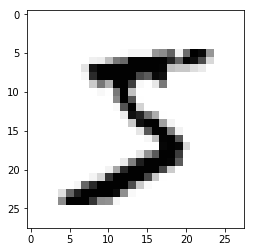

In [77]:
img = train_imgs[0].reshape((28,28))
plt.imshow(img, cmap="Greys")
plt.show()

In [90]:
import PIL
image = PIL.Image.fromarray(train_imgs[0].reshape((28,28)))

In [91]:
data_transform(image)

In [103]:
ds.transform(ds[0][0])

In [310]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader

white = 255
black = 0

def img_tranform(fill_color):
    return transforms.Compose([
        transforms.RandomRotation(360, fill=0),

        # Define size of image and randomly centers image
    #     transforms.RandomCrop(300, padding=None, pad_if_needed=True, padding_mode='constant', fill=white),
    #     transforms.Grayscale(num_output_channels=1),

        transforms.ColorJitter(brightness=(0.8, 1), contrast=(0.45, 1)),

    ])

operators_transform = transforms.Compose([
    # Grayscale
    transforms.Grayscale(num_output_channels=1),
    # Randomly scale up and down
    transforms.RandomAffine(0, scale=(0.9, 1.1), fillcolor=white),
    
    img_tranform(white),
])

minst_transform = transforms.Compose([
    # Scale up
    transforms.Pad(70),
    transforms.RandomAffine(0, scale=(2.5, 3.2), fillcolor=0),
    
    img_tranform(black),
])

# dataset_loader = torch.utils.data.DataLoader(hymenoptera_dataset,
#                                              batch_size=4, shuffle=True,
#                                              num_workers=4)


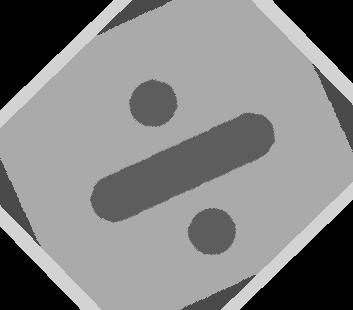

In [315]:
# Operators Dataset
operators_dataset = datasets.ImageFolder(root='../data/operators', transform=operators_transform)
operators_dataset.transform(operators_dataset[0][0])

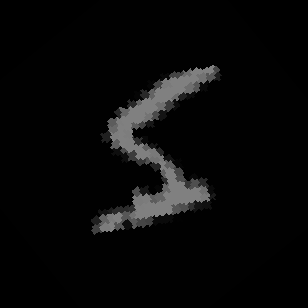

In [316]:
# Minst Dataset
minst_dataset = datasets.MNIST("", transform=minst_transform, download=True)
minst_dataset.transform(minst_dataset[0][0])

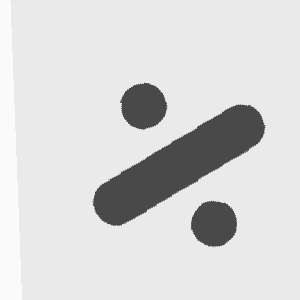

In [187]:
# Testing the transformer
image = data_transform(hymenoptera_dataset[0][0])
image